In [4]:
#!/usr/bin/env python
# coding: utf-8

In [5]:
# !pip install dask-expr
# !pip install opencv-python
# !pip install xarray
# !pip install pydap
# !pip install pyhdf
# !pip install basemap
# !pip install pygrib
# !pip install -U scikit-learn
# !pip install lightgbm
### Paste into Terminal
# sudo apt-get update
# sudo apt-get install libgl1-mesa-glx

In [6]:
import os

import sklearn
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GroupKFold

import lightgbm as lgb

import pandas as pd

import warnings
warnings.resetwarnings()
warnings.filterwarnings("ignore", category=DeprecationWarning)#
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore', category=sklearn.exceptions.ConvergenceWarning)
warnings.filterwarnings('ignore', category=sklearn.exceptions.FitFailedWarning)

from IPython.display import display
pd.set_option('display.max_columns', 100)

import cv2

import xarray as xr

import pydap

import h5py

from pyhdf.SD import SD, SDC

from mpl_toolkits.basemap import Basemap

import matplotlib as mpl

from joblib import Parallel, delayed

import random

import secrets

import datetime

import pygrib

import time

import zstandard as zstd

import tarfile

import io

import requests

import pickle

import subprocess

import json

import os

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.max_open_warning'] = 100

from collections import defaultdict

import numpy as np
pd.set_option('display.max_columns', 100)

In [7]:
zd = zstd.ZstdDecompressor()





SEED = datetime.datetime.now().microsecond


random.seed(datetime.datetime.now().microsecond); 
np.random.seed(datetime.datetime.now().microsecond)
run_label = secrets.token_hex(3)





dataset = 'tg'


ASSIM = True

In [8]:
labels = pd.read_csv('C:/nasa_tempo/nasa_tempo_jupyter/data_{}/train_labels.csv'.format(dataset))
grid = pd.concat((
    pd.read_csv('C:/nasa_tempo/nasa_tempo_jupyter/data_tg/grid_metadata.csv'),
    # pd.read_csv('data_pm/grid_metadata.csv')
)).drop_duplicates().reset_index(drop=True)

submission = pd.read_csv('C:/nasa_tempo/nasa_tempo_jupyter/data_{}/submission_format.csv'.format(dataset))
files = pd.read_csv('C:/nasa_tempo/nasa_tempo_jupyter/data_{}/{}_satellite_metadata{}.csv'.format(
                    dataset, *(('pm25', '') if dataset == 'pm'
                               else ('no2', '_0AF3h09'))))

labels['location'] = grid.set_index(
    'grid_id')['location'].reindex(labels.grid_id).values
labels['datetime'] = pd.to_datetime(labels.datetime)

submission['location'] = grid.set_index(
    'grid_id').location.reindex(submission.grid_id).values

# loc_dict = {'la': 'Los Angeles (SoCAB)', 'tpe': 'Taipei', 'dl': 'Delhi'}
loc_dict = {'la': 'Los Angeles (SoCAB)'}

In [9]:
coords = defaultdict(list)
for city, gcity in loc_dict.items():  # ['Delhi', 'Taipei', 'LA']:
    # gcity = [c for c in grid.location.unique() if 'Los A' in c][0] if city not in grid.location.unique() else city
    grid_points = grid[grid.location == gcity]
    for e in grid_points.itertuples():
        coords[city].append((e.grid_id, *np.array([(float(p.split(' ')[0]),
                                                    float(p.split(' ')[1]))
                                                   for p in e.wkt[10:].split(', ')[:4]]).mean(axis=0).round(4).tolist()))

In [10]:
# Clean Coords

def cleanDict(d):
    return {
        k: cleanDict(v) for k,
        v in d.items()} if isinstance(
        d,
        defaultdict) else d

assert sum([len(v) for c, v in coords.items()]) == grid.grid_id.nunique()
grid.grid_id.nunique()

coords = cleanDict(coords)

In [11]:
## Check/Validate 'ifs' files

# t = datetime.datetime(2016, 1, 1)
# # t = datetime.datetime(2020, 5, 26)
# while t < datetime.datetime.now() - datetime.timedelta(days = 1):
#     print(t)
#     for tag in ifs_tags:
#     # for tag in ifs_forecasts:# ifs_tags:#[:1]:
#         domain = 'ec.oper.an.sfc'
#         # domain = 'ec.oper.fc.sfc'
#         file =  '{}/{}/{}.{}.regn1280sc.{}.nc'.format(domain,
#                         datetime.datetime.strftime(t, '%Y%m'), 
#                         domain, tag, 
#                         datetime.datetime.strftime(t, '%Y%m%d') )
#         if file.split('/')[-1] not in existing_files:
#             sqs.send_message(
#                 QueueUrl='https://sqs.us-east-2.amazonaws.com/815054066888/aqi-ifs',
#                 MessageBody=json.dumps({'file': file}
#             ) )
#         # else:
#         #     print(file, 'exists')
#     t += datetime.timedelta(days = 1)
#     # break;

In [12]:
fields = ['nitrogendioxide_tropospheric_column',
 'nitrogendioxide_tropospheric_column_precision',
 'air_mass_factor_troposphere',
 'air_mass_factor_total']

In [13]:
trop_scr_dir = 'C:/nasa_tempo/nasa_tempo_jupyter/secure.txt'
with open(trop_scr_dir, 'r') as file:
    trop_secure = dict(e.split('=') for e in file.read().split('\n') if e)
download_dir = '/tmp/'

def loadFile(row):
    for i in range(1):
        try:
            values = {
                'email': trop_secure['username'],
                'passwd': trop_secure['password'],
                'action': 'login'}
            login_url = 'https://urs.earthdata.nasa.gov'
            ret = requests.post(login_url, data=values)
            if ret.status_code == 200:
                print("Login successful.")
            else:
                print("Bad Authentication")
                return None
        except Exception as e:
            print(e)
            time.sleep(i)
    zc = zstd.ZstdCompressor(level=15)
    os.makedirs(download_dir, exist_ok=True)
    filename, url, sz = [row[k]
                         for k in ['granule_id', 'us_url', 'granuleSize']]
    # print(filename, url, sz)
    file = '/tmp/' + filename
    try:
        print("Downloading", filename)
        if os.path.exists(file):
            print(f"{file} already exists. Skipping download.")
            pass
        with requests.get(url, cookies=ret.cookies,
                          allow_redirects=True, stream=True) as r:
            r.raise_for_status()
            with open(file, 'wb') as f:
                for chunk in r.iter_content(chunk_size=1024 * 1024):
                    f.write(chunk)
        print(f"Downloaded and compressed {filename} to {file}")
    except requests.RequestException as e:
        print(f"Error downloading {url}: {e}")
    return file

In [14]:
#  sklearn


#  warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning)#
# warnings.filterwarnings("ignore", category=FutureWarning)
# warnings.filterwarnings('ignore', category=sklearn.exceptions.ConvergenceWarning)
# warnings.filterwarnings('ignore', category=sklearn.exceptions.FitFailedWarning)

In [15]:
def run(hdf, location, fine=True):
    zones = {}  # defaultdict(dict)
    sat_data = defaultdict(lambda: defaultdict(dict))
    hp = hdf['PRODUCT']
    lat = hp['latitude'][:][0]  # .values
    lon = hp['longitude'][:][0]  # .values
    for field in fields:
        v = hp[field][:][0]
        data = np.ma.masked_array(
            v, (v == v.max()) | (
                v == v.min())).clip(
            0, None)
        assert data.shape == lat.shape
        for grid_id, plon, plat in coords[location]:
            for r in ([0.07, 0.1, 0.14, 0.2, 0.3, 0.5, 1, 2]
                      if fine else [0.1, 0.25, 0.5, 1, 2, ]):
                if (grid_id, r) not in zones:
                    zones[(grid_id, r)] = (lat - plat) ** 2 + \
                        (lon - plon) ** 2 < r ** 2
                zone = zones[(grid_id, r)]
                ct = data[zone].count()
                m = data[zone].mean() if ct > (0 if 'fine' else 3) else np.nan
                s = data[zone].std() if ct >= 3 else np.nan
                sat_data[grid_id][field + '_mean{}'.format(r)] = m
                sat_data[grid_id][field + '_stdev{}'.format(r)] = s
                sat_data[grid_id][field + '_count{}'.format(r)] = ct
                if '2' in grid_id:  # .startswith('9'):
                    print(field, '_count{}'.format(r), ct, m, s)
    return sat_data

In [16]:
def runTropomi(row, fine=True):
    assert row['product'].startswith('tropomi')

    # Presumably, loadFile is a function you've defined elsewhere to load the
    # data file
    file = loadFile(row)
    hdf = h5py.File(file, 'r')

    # Assuming run is a function you've defined that processes the hdf file
    # based on the location and 'fine' parameter
    sat_data = run(hdf, row['location'], fine)
    output = row.copy()

    # Assuming cleanDict is a function you've defined to clean or process the
    # satellite data in some way
    output['d1'] = cleanDict(sat_data)

    # Compress the serialized output
    zc = zstd.ZstdCompressor(level=15)
    o = pickle.dumps(output)
    c = zc.compress(o)

    # Save the compressed data locally
    local_dir = "path/to/your/local/directory"  # Specify your directory here
    filename = 'aqi_tropomi{}-{}.zst'.format(
        '-fine' if fine else '', os.path.basename(file))
    local_path = os.path.join(local_dir, filename)
    with open(local_path, 'wb') as f:
        f.write(c)
    os.remove(file)
    return {
        'statusCode': 200,
        'len': len(o),
        'clen': len(c),
        'body': json.dumps('Success'),
        'localPath': local_path  # Optionally return the path where the file was saved
    }

In [17]:
# runTropomi(rows[-4], fine = True)





# rows[-1]


# %%time
# Parallel(os.cpu_count() #// 2
#             )(delayed(runTropomi)(row) for row in rows)








# d = pd.to_datetime(files[(files['product'] == 'misr')
#        & (files.location == 'la')].time_end)
# d = d.sort_values().reset_index(drop = True)
# (d.diff().dt.total_seconds() / (60*60*24)).iloc[:].plot()








# coords['LA']














# sqs.send_message(
#     QueueUrl='https://sqs.us-east-2.amazonaws.com/815054066888/aqi-gfs25-extra',
#     MessageBody=json.dumps((2020, 1, 1, 6, 0))
# )


# t = datetime.datetime(2016, 10, 1)
# while t < datetime.datetime.now():
#     print(t)
#     for hr in range(0, 24, 6):
#         for fwd in (0, ):
#             sqs.send_message(
#                 QueueUrl='https://sqs.us-east-2.amazonaws.com/815054066888/aqi-gfs25-extra',
#                 MessageBody=json.dumps((t.year, t.month, t.day, hr, fwd))
#             )
#     t += datetime.timedelta(days = 1)











# [e[0] for e in pickle.loads(zd.decompress(
#     s3.get_object(Bucket = 'projects-v',
#               Key = 'aqi/gfs-5/{}'.format('gfs.0p25.2016100218.f000.grib2'))['Body'].read()
# )) if 'LA' in e[1]]


# [e[0] for e in pickle.loads(
#     s3.get_object(Bucket = 'projects-v',
#               Key = 'aqi/gfs/{}'.format('gfs.0p25.2016100112.f000.grib2'))['Body'].read()
# ) if 'LA' in e[1]]


# [e for e in pickle.loads(
#     s3.get_object(Bucket = 'projects-v',
#               Key = 'aqi/gfs/{}'.format('gfs.0p25.2019100612.f000.grib2'))['Body'].read()
# ) if 'metre temp' in e[0]]











# grid.wkt


# grid.sort_values('location').wkt


# p = pygrib.open(# 'gfs.0p25.2020072500.f000.grib2')#'gfs.0p25.2020010100.f000.grib2')
#     # 'gfs.0p25.2017072500.f000.grib2'
#     'gfs.0p25.2017072500.f000.grib2'
# )

In [18]:
# cities = {
# 'Taipei': ( (121.5, 121.5), (25.0, 25) ),
# 'Delhi': ( (77.0, 77.25), (28.75, 28.5) ),
# 'LA': ((360-118.25, 360-117.75), (34.0, 34.0) )
# }

cities = {
    'LA': ((360 - 118.25, 360 - 117.75), (34.0, 34.0))
}

In [19]:
# for city in ['Delhi', 'Taipei', 'LA']:
for city in ['LA']:
    # Ensure the list exists for the city key
    coords.setdefault(city, [])

    gcity = [c for c in grid.location.unique() if 'Los A' in c][0] if city not in grid.location.unique() else city
    grid_points = grid[grid.location == gcity]
    for e in grid_points.itertuples():
        coords[city].append((e.grid_id, *np.array([(float(p.split(' ')[0]),
                                                    float(p.split(' ')[1]))
                                                   for p in e.wkt[10:].split(', ')[:4]]).mean(axis=0).tolist()))

### Load Saved Features

In [20]:
def loadFiles(file):
    zd = zstd.ZstdDecompressor()
    data = []
    with tarfile.TarFile(file, 'r') as tar:
        assim_files = tar.getnames()
        for file in assim_files:
            if len(file) > 0:
                f = tar.extractfile(file)
                data.append(pickle.loads(zd.decompress(f.read())))
    return data

In [21]:
# def listFiles(prefix, bucket = 'projects-v'): 
#     paginator = s3.get_paginator('list_objects_v2')
#     page_iterator = paginator.paginate(Bucket = bucket,
#                                        Prefix = prefix )
#     files = []
#     for page in page_iterator:
#         files.extend([e['Key'] for e in page['Contents']])
#     return files


# def listFiles(prefix):
#     return [os.path.join('cache/', prefix[4:], f) 
#             for f in os.listdir('cache/' + prefix[4:])]








# def loadData(file):
#     zd = zstd.ZstdDecompressor()
#     data = pickle.loads(zd.decompress(open(file, 'rb').read()))
#     return data

In [22]:
def flatten(l): return [e for s in l for e in s]

In [23]:
# loc_dict = {'la': 'Los Angeles (SoCAB)', 'tpe': 'Taipei', 'dl': 'Delhi'}
loc_dict = {'la': 'Los Angeles (SoCAB)'}

rloc_dict = {v: k for k, v in loc_dict.items()}

tz_dict = grid.groupby('location').tz.first().to_dict()

loc_tz_dict = {rloc_dict[k]: v for k, v in tz_dict.items()}
loc_tz_dict

{'la': 'Etc/GMT+8'}

In [24]:
# def downloadFile(file):
#     s3 = boto3.client('s3')
#     s3.download_file('projects-v', file, 'cache/' + file[4:])


# def downloadFiles(files):
#     for path in set([f.split('/')[1] for f in files]):
#         os.makedirs('cache/{}'.format(path), exist_ok = True)
                    
#     Parallel(os.cpu_count() * 3)(delayed(downloadFile)(file)
#                                      for file in files)

# downloadFiles(assim_files)

In [25]:
all_data_assim = loadFiles('C:/nasa_tempo/nasa_tempo_jupyter/cache/assim.tar')

all_data_assim = flatten(all_data_assim)

len(all_data_assim)

132960

In [26]:
rt_dict = {}

def process(d, e):
    t = d['time_end']
    if t not in rt_dict:
        rt = (t + 30).astype('datetime64[m]')
        rt_dict[t] = rt
    rt = rt_dict[t]
    grid_data_assim[grid_id][rt].update(e)
    grid_data_assim[grid_id][rt].update({'location': d['location']})

In [27]:
grid_data_assim = defaultdict(lambda: defaultdict(dict))
for d in all_data_assim:
    for grid_id, e in d['d1'].items():
        process(d, e)

In [28]:
def processAssim(grid_id, v):
    df = pd.DataFrame.from_dict(v, orient= 'index')
    
    # tz
    assert df.location.nunique() == 1 
    tz = loc_tz_dict[df.location.unique()[0]]
    df.index = df.index.tz_localize('UTC').tz_convert(tz).floor('1d')
    df.index.name = 'datetime'
    df.drop(columns = 'location', inplace = True)
    df = df.groupby(df.index).mean()#.sort_index()#.head(10)    

    # fill
    t = pd.to_datetime(submission.datetime.min()).tz_convert(tz).floor('1d')
    tf = pd.to_datetime(submission.datetime.max()).tz_convert(tz).floor('1d')
    df_t = set(df.index)
    extra_times = []
    while t <= tf:
        if t not in df_t:
            extra_times.append(t)
        t += datetime.timedelta(days = 1)
    df_extra = pd.DataFrame(np.nan, index = pd.Series(extra_times), columns = df.columns )
    df = pd.concat((df, df_extra)).sort_index()
    
    
    # ewm     
    n = 1
    df_ewm1 = df.ewm(span = n).mean().astype(np.float32).fillna(df.mean())
    df_ewm1.columns = [c + '_{}day'.format(n) for c in df.columns]

    n = 2
    df_ewm2 = df.ewm(span = n).mean().astype(np.float32).fillna(df.mean())
    df_ewm2.columns = [c + '_{}day'.format(n) for c in df.columns]

    n = 5
    df_ewm5 = df.ewm(span = n).mean().astype(np.float32).fillna(df.mean())
    df_ewm5.columns = [c + '_{}day'.format(n) for c in df.columns]
        
    # raw_df = df
    df = pd.concat((df_ewm1, df_ewm2, df_ewm5,
                   ), axis = 1)
    
    # compile
    df.index = df.index.tz_localize(None)
    df.insert(0, 'grid_id', grid_id)
    return df;

In [29]:
all_dfs = Parallel(os.cpu_count())(delayed(processAssim)(grid_id, v)
                                   for grid_id, v in grid_data_assim.items() )


In [30]:
assim = pd.concat(all_dfs)
assim.index.name = 'datetime'
assim = assim.reset_index().set_index(['datetime', 'grid_id'])

del all_data_assim, grid_data_assim, all_dfs

In [31]:
all_data_tropomi = loadFiles('C:/nasa_tempo/nasa_tempo_jupyter/cache/tropomi-fine.tar')
len(all_data_tropomi)

1428

In [32]:
grid_data_tropomi = defaultdict(list)
for d in all_data_tropomi:
    for grid_id, e in d['d1'].items():
        # e = blend(e)#e.copy()
        e['datetime'] = d['time_end']
        e['location'] = d['location']
        grid_data_tropomi[grid_id].append(e)
    # break;

In [33]:
all_dfs = []
for grid_id, v in grid_data_tropomi.items():
    df = pd.DataFrame(v)

    # tz
    assert df.location.nunique() == 1 
    tz = loc_tz_dict[df.location.unique()[0]]
    df.datetime = pd.to_datetime(df.datetime).dt.tz_convert(tz).dt.floor('1d')
    df.drop(columns = 'location', inplace = True)

    # group
    for col in [c for c in df.columns if '_mean' in c]:
        ct = np.where(df[col].isnull(), 0, df[col.replace('_mean', '_count')] )
        df[col.replace('_mean', '_sum')] = df[col] * ct
        df[col.replace('_mean', '_count')] = ct
    df = df.groupby(df.datetime).sum()#.sort_index()#.head(10)
    

    for col in [c for c in df.columns if '_mean' in c]:
        df[col] = (df[col.replace('_mean', '_sum')] 
                                / df[col.replace('_mean', '_count')]
                    )
    # filter
    df = df[[c for c in df.columns if
             ('.' in  c) and 
             ( ( '_mean' in c ) or ('column_stdev' in c) )
            ]]
    
    # fill
    t = pd.to_datetime(submission.datetime.min()).tz_convert(tz).floor('1d')
    tf = pd.to_datetime(submission.datetime.max()).tz_convert(tz).floor('1d')
    df_t = set(df.index)
    extra_times = []
    while t <= tf:
        if t not in df_t:
            extra_times.append(t)
        t += datetime.timedelta(days = 1)
    df_extra = pd.DataFrame(np.nan, index = pd.Series(extra_times), columns = df.columns )
    df = pd.concat((df, df_extra)).sort_index()
        
    # clip
    sigma = 4
    high = df.ewm(span = 100).mean() + sigma * df.ewm(span = 100).std().fillna(100000)
    df = df.clip(0, None)
    df = np.minimum(df, high)
    
    # ewm     
    n = 1
    df_ewm1 = df.ewm(span = n).mean().astype(np.float32).fillna(df.mean())
    df_ewm1.columns = [c + '_{}day'.format(n) for c in df.columns]

    n = 3
    df_ewm3 = df.ewm(span = n).mean().astype(np.float32).fillna(df.mean())
    df_ewm3.columns = [c + '_{}day'.format(n) for c in df.columns]
    
    raw_df = df
    df = pd.concat((df_ewm1, df_ewm3, 
                   ), axis = 1)
    
    # compile
    df.index = df.index.tz_localize(None)
    df.insert(0, 'grid_id', grid_id)
    all_dfs.append(df)


tropomi = pd.concat(all_dfs)
tropomi.index.name = 'datetime'
tropomi = tropomi.reset_index().set_index(['datetime', 'grid_id'])


del all_data_tropomi, grid_data_tropomi, all_dfs

In [34]:
# %%time
# downloadFiles(ifs_files)





# def loadData(f):
#     s3 = boto3.client('s3')
#     zd = zstd.ZstdDecompressor()
#     data = pickle.loads(zd.decompress(s3.get_object(Bucket = 'projects-v', Key = f)['Body'].read()))    
#     return data








# ifs_files = sorted(listFiles('aqi/ifs/'));


# ifs_tags = [
#     '128_015_aluvp', '128_134_sp', '128_136_tcw', 
#     # '128_137_tcwv', 
# '128_164_tcc',	   
#  '128_165_10u',
# '128_166_10v',
#  '128_167_2t',
# '128_168_2d',	
# '128_206_tco3',  	
# '228_246_100u',	   
# '228_247_100v',  	   
# ]


# ifs_files = [f for f in ifs_files # if any(z in f for z in ifs_tags) 
#                     if '.oper.fc'  in f
#             ]


# len(ifs_files)#[::1000]








# def loadData(f):
#     s3 = boto3.client('s3')
#     data = s3.get_object(Bucket = 'projects-v', Key = f)['Body'].read() 
#     return data


# %%time
# all_data_ifs = Parallel(os.cpu_count() * 3)(delayed(loadData)(d) for d in 
#                         [f for f in ifs_files[::1] ])
# # data = flatten(all_data)





# %%time
all_data_ifs = loadFiles('C:/nasa_tempo/nasa_tempo_jupyter/cache/ifs.tar')
len(all_data_ifs)




# with tarfile.open('cache/ifs.tar', "w") as tar:
#     for file, data in zip(ifs_files[:], all_data_ifs[:]):
#         t = tarfile.TarInfo(name = file)
#         t.size = len(data)
#         b = io.BytesIO(data)
#         b.seek(0)
#         tar.addfile(
#             t, b)
#         # print(b)

25484

In [35]:
grid_data_ifs = defaultdict(lambda: defaultdict(dict))
for d in all_data_ifs:
    for dt, v in d.items():
        for grid_id, e in v.items():
            # e['timezone'] = grid_tz_dict[grid_id]#d['location']
            grid_data_ifs[grid_id][dt[0]].update(e)

In [36]:
all_dfs = []
# def compileIfs(grid_id, v):
for grid_id, v in grid_data_ifs.items():
    df = pd.DataFrame(v).T
    df.index.name = 'datetime'
    # df.sort_index(inplace = True)
    df = df.reset_index()
    df.sort_values('datetime', inplace = True)
    
    # break;
    extra_rows = []
    t = df.datetime.min()
    timestamps = set(df.datetime)
    t_max = df.datetime.max()
    while t < t_max:#max(timestamps):#df.datetime.max():
        t_next = t + datetime.timedelta(seconds = 60 * 60 * 12) 
        if t_next not in timestamps:
            if grid_id == '1X116': print(t_next)
            extra = df[df.datetime == t].copy() #if not last else last.copy()
            extra.datetime = t_next
            extra_rows.append(extra)
            # last = extra
        # else:
            # last = None
        t = t_next;
    if len(extra_rows) > 1 and grid_id == '1X116': 
        print('{} extra rows'.format(len(extra_rows)))
    df = pd.concat((df, *extra_rows))
    
    df.set_index('datetime', inplace = True)    

    # df = addExtraRows(df.reset_index()).set_index('datetime')    
    df = df.ewm(span = 2 * 2).mean().astype(np.float32)
    df.columns = [c + '_{}day'.format(2) for c in df.columns]

        
    # compile
    df.index = df.index.tz_localize(None)
    df.drop(columns = [c for c in df.columns if 'vapour' in c 
                       or 'mean0.05' in c 
                       or 'mean0.2' in c
                       or 'mean1' in c
                       or 'roughness' in c
                       or 'albedo' in c
                      ], inplace = True)
    df.columns = ['ifs_'+ c for c in df.columns]
    df.insert(0, 'grid_id', grid_id)
    # return df;

    all_dfs.append(df)
    # break;
    # break;

# all_dfs = Parallel(#os.cpu_count() * 2
#                   1)(delayed(compileIfs)(grid_id, v) 
#                            for grid_id, v in grid_data_ifs.items())


ifs = pd.concat(all_dfs)
ifs.index.name = 'datetime'
ifs = ifs.reset_index().set_index(['datetime', 'grid_id'])

Los Angeles (SoCAB)


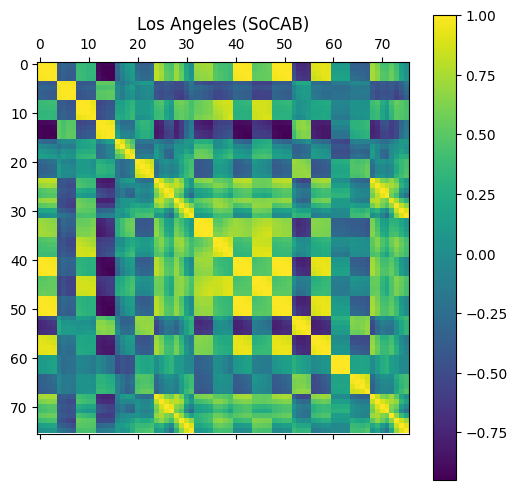

Los Angeles (SoCAB)


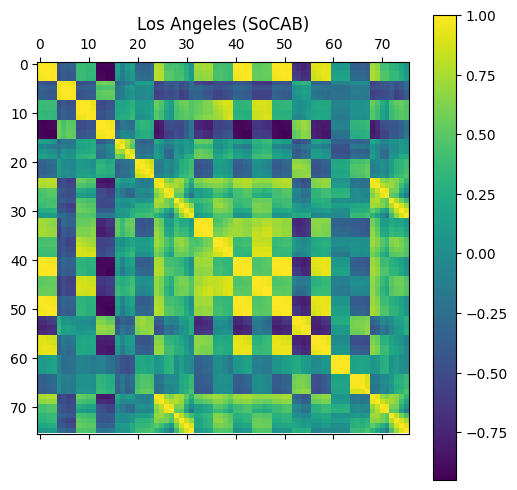

Los Angeles (SoCAB)


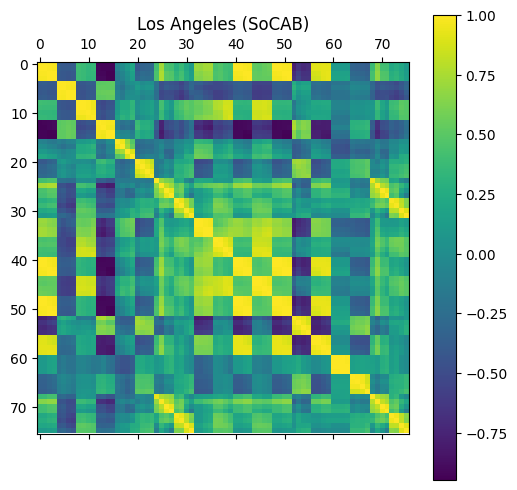

In [37]:
for i in [0, 10, -1]:
    df = all_dfs[i]
    df['grid_id'] = df['grid_id'].astype(str)
    grid['grid_id'] = grid['grid_id'].astype(str)  # Ensure grid_id is string
    try:
        location = grid.set_index('grid_id').location[df.grid_id.iloc[0]]
        print(location)
    except KeyError:
        print(f"Location for grid_id {df['grid_id'].iloc[0]} not found.")
        location = "Unknown Location"  # Default or placeholder location
    df_numeric = df.select_dtypes(include=[np.number])
    plt.matshow(df_numeric.corr())
    plt.colorbar()
    plt.title(location)
    plt.show()  # Ensure the plot is shown for each iteration
    # plt.matshow(df.corr()); plt.colorbar(); plt.title(str(location))

df.columns[1::6]

del all_data_ifs, grid_data_ifs, all_dfs

In [38]:
# gfs_files = listFiles('aqi/gfs-5/')


# len(gfs_files)


# with tarfile.open('cache/gfs-5.tar', "w") as tar:
#     tar.add('cache/gfs-5/', arcname=os.path.sep)


# %%time
# all_data_gfs = Parallel(os.cpu_count() * 3)(delayed(loadData)(d) for d in 
#                         [f for f in gfs_files if 'f000' in f])
# all_data_gfs = flatten(all_data_gfs)

In [39]:
# %%time
all_data_gfs = loadFiles('C:/nasa_tempo/nasa_tempo_jupyter/cache/gfs-5.tar')
all_data_gfs = flatten(all_data_gfs)


len(all_data_gfs)

53184

In [40]:
points = defaultdict(lambda: defaultdict(list))
for e in all_data_gfs:# [e for e in h if e[1] == city]:
    t = datetime.datetime.strptime(e[0][-12:-2], '%Y%m%d%H')
    n = ':'.join(e[0].split(':')[1:2])
    city = e[1]
    
    arr = e[3] 
    arr2 = cv2.resize(arr, None, fx = 5, fy = 5,  )
    
    for grid_id, x, y in coords[city]:
        v = arr2[ int(round(( e[2][0][1] - y ) / 0.05 + 2)), 
            int(round( ( (x % 360) - e[2][1][0] )/0.05 + 2 ) ) ]
        points[grid_id][n].append((t, v, e[-1]))

In [41]:
def addExtraRows(df):
    extra_rows = []
    t = df.datetime.min()
    timestamps = set(df.datetime)
    t_max = df.datetime.max()
    last = pd.DataFrame()  # Initialize 'last' as an empty DataFrame here
    while t < t_max:  # Iterate until the max datetime
        t_next = t + datetime.timedelta(seconds=60 * 60 * 6)
        if t_next not in timestamps:
            # Check if 'last' is empty using '.empty'
            extra = df[df.datetime == t].copy() if not last.empty else last.copy()
            extra.datetime = t_next
            extra_rows.append(extra)
            last = extra
        else:
            # Reset 'last' to an empty DataFrame instead of None
            last = pd.DataFrame()
        t = t_next
    if len(extra_rows) > 0:
        print('{} extra rows'.format(len(extra_rows)))
    # Return the original DataFrame concatenated with any extra rows
    return pd.concat([df] + extra_rows, ignore_index=True)

In [42]:
all_dfs = []
for grid_point, grid_data in points.items():
    dfs = []
    for label, d in grid_data.items():
        if 'Volumetric soil moisture content' in label: continue;
        df = pd.DataFrame(d, 
                     columns = ['datetime', label + '_local', label + '_city'])
        df.sort_values('datetime', inplace = True)
        dfs.append(df.set_index('datetime'))
                
    df = pd.concat(dfs, axis = 1)
    df = addExtraRows(df.reset_index()).set_index('datetime')    
    df = df.ewm(span = 4 * 3).mean().astype(np.float32)
    df.columns = [c + '_{}day'.format(3) for c in df.columns]
    df['grid_id'] = grid_point
    all_dfs.append(df)
gfs = pd.concat(all_dfs)
gfs = gfs.reset_index().set_index(['datetime', 'grid_id'])
#
        # print(df.corr().iloc[0, 1], label)
        # break;

In [43]:
del all_data_gfs, points, all_dfs

In [44]:
labels['dayofweek'] = labels.datetime.dt.dayofweek.astype(np.int32)


labels['dayinyear'] = labels.datetime.dt.dayofyear.astype(np.int32)


labels.head()

,datetime,grid_id,value,location,dayofweek,dayinyear
0,2019-01-01 08:00:00+00:00,3A3IE,8.695000,Los Angeles (SoCAB),1,1
1,2019-01-01 08:00:00+00:00,3S31A,10.496667,Los Angeles (SoCAB),1,1
2,2019-01-01 08:00:00+00:00,7II4T,37.208333,Los Angeles (SoCAB),1,1
3,2019-01-01 08:00:00+00:00,8BOQH,9.791667,Los Angeles (SoCAB),1,1
4,2019-01-01 08:00:00+00:00,A2FBI,4.308333,Los Angeles (SoCAB),1,1


In [45]:
def addGFS(labels):
    ldo = pd.to_datetime(labels.datetime).dt.floor('6h').dt.tz_localize(None)
    df = pd.concat( ( labels, 
            * [2/3 * gfs.reindex([ldo
                                + datetime.timedelta(seconds = 60 * 60 * 12), 
                             labels.grid_id]).reset_index(drop = True) 
               + 1/3 * gfs.reindex([ldo
                                + datetime.timedelta(seconds = 60 * 60 * 18), 
                             labels.grid_id]).reset_index(drop = True) 
                  #for k, v in gfs_ewms.items() 
              ],                       
                      ), axis = 1)
    return df

# gfs.groupby(['datetime', 'grid_id']).nunique().mean(axis = 1).sort_values()[-50:]

def ifsoffset12(c): return c.replace('ifs', 'ifs12')
def ifsoffset0(c): return c.replace('ifs', 'ifs0')

In [46]:
def addIFS(labels):
    ldo = pd.to_datetime(labels.datetime).dt.floor('12h').dt.tz_localize(None)
    df = pd.concat( ( labels, 
            * [ifs.reindex([ldo
                                + datetime.timedelta(seconds = 60 * 60 * 12), 
                             labels.grid_id]).reset_index(drop = True).rename(
                                   columns = ifsoffset12)

                , 
               ifs.reindex([ldo
                                # + datetime.timedelta(seconds = 60 * 60 * 0)
                                    , 
                             labels.grid_id]).reset_index(drop = True).rename(
                   columns = ifsoffset0)
                  #for k, v in gfs_ewms.items() 
              ],                       
                      ), axis = 1)
    return df

In [47]:
def addSat(labels, sat):
    
    tza = labels.datetime.copy()
    for location in labels.location.unique():
        t = pd.to_datetime(labels.datetime).dt.tz_convert( tz_dict[location] )
        t = t.dt.floor('1d').dt.tz_localize(None)
        tza = np.where(labels.location == location, t, tza)
    tza = pd.to_datetime(pd.Series(tza, index = labels.index))

    df = pd.concat( ( labels, 
            sat.reindex([tza,
                             labels.grid_id]).reset_index(drop = True) 
                     
                      ), axis = 1)
    return df

In [48]:
all_data = addGFS(labels)
all_data = addIFS(all_data)
all_data = addSat(all_data, maiac if dataset == 'pm' else tropomi)
if ASSIM: all_data = addSat(all_data, assim)
# all_data = addSat(all_data, misr)


all_data.tail()


all_data.head()

,datetime,grid_id,value,location,dayofweek,dayinyear,Wind speed (gust)_local_3day,Wind speed (gust)_city_3day,Surface pressure_local_3day,Surface pressure_city_3day,2 metre temperature_local_3day,2 metre temperature_city_3day,2 metre specific humidity_local_3day,2 metre specific humidity_city_3day,2 metre relative humidity_local_3day,2 metre relative humidity_city_3day,Apparent temperature_local_3day,Apparent temperature_city_3day,10 metre U wind component_local_3day,10 metre U wind component_city_3day,10 metre V wind component_local_3day,10 metre V wind component_city_3day,Cloud water_local_3day,Cloud water_city_3day,Relative humidity_local_3day,Relative humidity_city_3day,Total ozone_local_3day,Total ozone_city_3day,ifs12_downward_uv_radiation_at_the_surface_mean0.1_2day,ifs12_downward_uv_radiation_at_the_surface_mean0.5_2day,ifs12_downward_uv_radiation_at_the_surface_mean2_2day,ifs12_downward_uv_radiation_at_the_surface_mean5_2day,ifs12_surface_pressure_mean0.1_2day,ifs12_surface_pressure_mean0.5_2day,ifs12_surface_pressure_mean2_2day,ifs12_surface_pressure_mean5_2day,ifs12_total_column_water_mean0.1_2day,ifs12_total_column_water_mean0.5_2day,ifs12_total_column_water_mean2_2day,ifs12_total_column_water_mean5_2day,ifs12_surface_sensible_heat_flux_mean0.1_2day,ifs12_surface_sensible_heat_flux_mean0.5_2day,ifs12_surface_sensible_heat_flux_mean2_2day,ifs12_surface_sensible_heat_flux_mean5_2day,ifs12_surface_latent_heat_flux_mean0.1_2day,ifs12_surface_latent_heat_flux_mean0.5_2day,ifs12_surface_latent_heat_flux_mean2_2day,ifs12_surface_latent_heat_flux_mean5_2day,ifs12_total_cloud_cover_mean0.1_2day,ifs12_total_cloud_cover_mean0.5_2day,...,co_mean0.1_2day,co_mean0.25_2day,co_mean0.5_2day,co_mean1_2day,co_mean2_2day,no2_mean0.1_2day,no2_mean0.25_2day,no2_mean0.5_2day,no2_mean1_2day,no2_mean2_2day,o3_mean0.1_2day,o3_mean0.25_2day,o3_mean0.5_2day,o3_mean1_2day,o3_mean2_2day,pm25_rh35_gcc_mean0.1_2day,pm25_rh35_gcc_mean0.25_2day,pm25_rh35_gcc_mean0.5_2day,pm25_rh35_gcc_mean1_2day,pm25_rh35_gcc_mean2_2day,so2_mean0.1_2day,so2_mean0.25_2day,so2_mean0.5_2day,so2_mean1_2day,so2_mean2_2day,co_mean0.1_5day,co_mean0.25_5day,co_mean0.5_5day,co_mean1_5day,co_mean2_5day,no2_mean0.1_5day,no2_mean0.25_5day,no2_mean0.5_5day,no2_mean1_5day,no2_mean2_5day,o3_mean0.1_5day,o3_mean0.25_5day,o3_mean0.5_5day,o3_mean1_5day,o3_mean2_5day,pm25_rh35_gcc_mean0.1_5day,pm25_rh35_gcc_mean0.25_5day,pm25_rh35_gcc_mean0.5_5day,pm25_rh35_gcc_mean1_5day,pm25_rh35_gcc_mean2_5day,so2_mean0.1_5day,so2_mean0.25_5day,so2_mean0.5_5day,so2_mean1_5day,so2_mean2_5day
0,2019-01-01 08:00:00+00:00,3A3IE,8.695000,Los Angeles (SoCAB),1,1,5.413679,4.403292,92828.007812,100089.90625,281.026093,286.235413,0.002560,0.002854,35.595852,30.025583,279.274139,286.091034,-2.047880,-1.76149,-1.687304,-0.21584,0.004267,0.005275,10.903458,12.244355,329.625122,332.235718,745171.8750,739461.6875,711426.5000,690866.3750,97174.710938,94290.960938,95142.187500,95286.648438,4.466324,3.908245,4.787787,6.222759,-1149612.625,-1676964.875,-1217090.750,-1097625.125,-1.568464e+06,-6.496657e+05,-2806355.0,-3111115.75,0.044663,0.039892,...,2.645851e-07,2.654458e-07,2.435152e-07,1.861290e-07,1.489865e-07,1.072726e-08,1.084041e-08,9.688059e-09,5.729664e-09,2.602033e-09,2.922568e-08,2.909989e-08,3.022860e-08,3.413607e-08,3.754369e-08,13.694448,13.684081,12.449080,9.186067,7.114766,3.690123e-10,3.700938e-10,3.349736e-10,2.383904e-10,1.841198e-10,3.293613e-07,3.280886e-07,2.926124e-07,2.129792e-07,1.612483e-07,1.407059e-08,1.402868e-08,1.211337e-08,6.980736e-09,3.080813e-09,2.672559e-08,2.674875e-08,2.853741e-08,3.329452e-08,3.720178e-08,21.200350,21.053583,18.760553,13.533575,9.749266,4.287931e-10,4.265869e-10,3.683897e-10,2.396264e-10,1.726736e-10
1,2019-01-01 08:00:00+00:00,3S31A,10.496667,Los Angeles (SoCAB),1,1,5.968803,4.403292,100819.125000,100089.90625,286.146179,286.235413,0.003239,0.002854,34.337368,30.025583,285.988281,286.091034,-2.845850,-1.76149,-0.686538,-0.21584,0.008124,0.005275,12.777002,12.2

In [49]:
x = all_data[[c for c in all_data.columns if c not in ['datetime', 'value']]].copy()
x.head()

# Check all data
# x_3a3ie = x[x['grid_id'] == '3A3IE']
# print(x_3a3ie)

# Exists?
# exist = x[x['grid_id'] == 'HANW9'].any()
# print(exist)

,grid_id,location,dayofweek,dayinyear,Wind speed (gust)_local_3day,Wind speed (gust)_city_3day,Surface pressure_local_3day,Surface pressure_city_3day,2 metre temperature_local_3day,2 metre temperature_city_3day,2 metre specific humidity_local_3day,2 metre specific humidity_city_3day,2 metre relative humidity_local_3day,2 metre relative humidity_city_3day,Apparent temperature_local_3day,Apparent temperature_city_3day,10 metre U wind component_local_3day,10 metre U wind component_city_3day,10 metre V wind component_local_3day,10 metre V wind component_city_3day,Cloud water_local_3day,Cloud water_city_3day,Relative humidity_local_3day,Relative humidity_city_3day,Total ozone_local_3day,Total ozone_city_3day,ifs12_downward_uv_radiation_at_the_surface_mean0.1_2day,ifs12_downward_uv_radiation_at_the_surface_mean0.5_2day,ifs12_downward_uv_radiation_at_the_surface_mean2_2day,ifs12_downward_uv_radiation_at_the_surface_mean5_2day,ifs12_surface_pressure_mean0.1_2day,ifs12_surface_pressure_mean0.5_2day,ifs12_surface_pressure_mean2_2day,ifs12_surface_pressure_mean5_2day,ifs12_total_column_water_mean0.1_2day,ifs12_total_column_water_mean0.5_2day,ifs12_total_column_water_mean2_2day,ifs12_total_column_water_mean5_2day,ifs12_surface_sensible_heat_flux_mean0.1_2day,ifs12_surface_sensible_heat_flux_mean0.5_2day,ifs12_surface_sensible_heat_flux_mean2_2day,ifs12_surface_sensible_heat_flux_mean5_2day,ifs12_surface_latent_heat_flux_mean0.1_2day,ifs12_surface_latent_heat_flux_mean0.5_2day,ifs12_surface_latent_heat_flux_mean2_2day,ifs12_surface_latent_heat_flux_mean5_2day,ifs12_total_cloud_cover_mean0.1_2day,ifs12_total_cloud_cover_mean0.5_2day,ifs12_total_cloud_cover_mean2_2day,ifs12_total_cloud_cover_mean5_2day,...,co_mean0.1_2day,co_mean0.25_2day,co_mean0.5_2day,co_mean1_2day,co_mean2_2day,no2_mean0.1_2day,no2_mean0.25_2day,no2_mean0.5_2day,no2_mean1_2day,no2_mean2_2day,o3_mean0.1_2day,o3_mean0.25_2day,o3_mean0.5_2day,o3_mean1_2day,o3_mean2_2day,pm25_rh35_gcc_mean0.1_2day,pm25_rh35_gcc_mean0.25_2day,pm25_rh35_gcc_mean0.5_2day,pm25_rh35_gcc_mean1_2day,pm25_rh35_gcc_mean2_2day,so2_mean0.1_2day,so2_mean0.25_2day,so2_mean0.5_2day,so2_mean1_2day,so2_mean2_2day,co_mean0.1_5day,co_mean0.25_5day,co_mean0.5_5day,co_mean1_5day,co_mean2_5day,no2_mean0.1_5day,no2_mean0.25_5day,no2_mean0.5_5day,no2_mean1_5day,no2_mean2_5day,o3_mean0.1_5day,o3_mean0.25_5day,o3_mean0.5_5day,o3_mean1_5day,o3_mean2_5day,pm25_rh35_gcc_mean0.1_5day,pm25_rh35_gcc_mean0.25_5day,pm25_rh35_gcc_mean0.5_5day,pm25_rh35_gcc_mean1_5day,pm25_rh35_gcc_mean2_5day,so2_mean0.1_5day,so2_mean0.25_5day,so2_mean0.5_5day,so2_mean1_5day,so2_mean2_5day
0,3A3IE,Los Angeles (SoCAB),1,1,5.413679,4.403292,92828.007812,100089.90625,281.026093,286.235413,0.002560,0.002854,35.595852,30.025583,279.274139,286.091034,-2.047880,-1.76149,-1.687304,-0.21584,0.004267,0.005275,10.903458,12.244355,329.625122,332.235718,745171.8750,739461.6875,711426.5000,690866.3750,97174.710938,94290.960938,95142.187500,95286.648438,4.466324,3.908245,4.787787,6.222759,-1149612.625,-1676964.875,-1217090.750,-1097625.125,-1.568464e+06,-6.496657e+05,-2806355.0,-3111115.75,0.044663,0.039892,0.075970,0.208282,...,2.645851e-07,2.654458e-07,2.435152e-07,1.861290e-07,1.489865e-07,1.072726e-08,1.084041e-08,9.688059e-09,5.729664e-09,2.602033e-09,2.922568e-08,2.909989e-08,3.022860e-08,3.413607e-08,3.754369e-08,13.694448,13.684081,12.449080,9.186067,7.114766,3.690123e-10,3.700938e-10,3.349736e-10,2.383904e-10,1.841198e-10,3.293613e-07,3.280886e-07,2.926124e-07,2.129792e-07,1.612483e-07,1.407059e-08,1.402868e-08,1.211337e-08,6.980736e-09,3.080813e-09,2.672559e-08,2.674875e-08,2.853741e-08,3.329452e-08,3.720178e-08,21.200350,21.053583,18.760553,13.533575,9.749266,4.287931e-10,4.265869e-10,3.683897e-10,2.396264e-10,1.726736e-10
1,3S31A,Los Angeles (SoCAB),1,1,5.968803,4.403292,100819.125000,100089.90625,286.146179,286.235413,0.003239,0.002854,34.337368,30.025583,285.988281,286.091034,-2.845850,-1.76149,-0.686538,-0.21584,0.008124,0.005275,12.777002,12

In [50]:
# '7334C' - > '7F1D1'
# 'HANW9' - > 'WZNCR'
# if '7F1D1' not in x['grid_id'].cat.categories:
#     x['grid_id'] = x['grid_id'].cat.add_categories(['7F1D1'])

# if 'WZNCR' not in x['grid_id'].cat.categories:
#     x['grid_id'] = x['grid_id'].cat.add_categories(['WZNCR'])

if dataset == 'tg':
    np.random.seed(SEED)
    # x.loc[(x.grid_id == '7334C') & (np.random.random(len(x)) < 0.1), 'grid_id'] = '7F1D1'
    # x.loc[(x.grid_id == 'HANW9') & (np.random.random(len(x)) < 0.1), 'grid_id'] = 'WZNCR'


x.grid_id = x.grid_id.astype('category');
x.location = x.location.astype('category');

y = all_data.value.astype(np.float32)
d = all_data.datetime


# with open('C:/nasa_tempo/nasa_tempo_jupyter/cache/all_data_{}.pkl'.format(dataset), 'wb') as pckl_file:
#     pickle.dump(all_data, pckl_file)
pickle.dump(all_data, open('cache/all_data_{}.pkl'.format(dataset), 'wb'))

C:\Users\mlertsmi\AppData\Local\Temp\3\ipykernel_18244\2765329298.py:24: ResourceWarning: unclosed file <_io.BufferedWriter name='cache/all_data_tg.pkl'>
  pickle.dump(all_data, open('cache/all_data_{}.pkl'.format(dataset), 'wb'))


In [51]:
x.columns = [c.replace(':', '_') for c in x.columns]

# Verify no NaN values remain
#assert x.isnull().sum().sum() == 0
x.shape

(17473, 313)

In [52]:
# x.fillna(method = 'ffill')


#x.isnull().sum()


#x.isnull().sum().sort_values()

In [53]:
# Select only numerical columns
#numerical_cols = x.select_dtypes(include=['number']).columns
# Replace NaN with the mean in numerical columns only
#x[numerical_cols] = x[numerical_cols].fillna(x[numerical_cols].mean())

assert x.isnull().sum().sum() == 0

In [54]:
enet_params = {
    'alpha': [  1e-2, 3e-2, 1e-1, 0.3, 1, 3, ],
    'l1_ratio': [ 0.01, 0.03, 0.1, 0.2, 0.5, 0.8, 0.9, ],
}

In [55]:
class PurgedKFold():
    def __init__(self, n_splits=5, gap = 30):
        self.n_splits = n_splits
        self.gap = gap
        
    def get_n_splits(self, X, y = None, groups = None): return self.n_splits
    
    def split(self, X, y=None, groups=None):
        # Ensure 'groups' is a Series and convert to datetime if not already
        if not isinstance(groups, pd.Series):
            groups = pd.Series(groups)
        if not pd.api.types.is_datetime64_any_dtype(groups):
            groups = pd.to_datetime(groups)

        groups = groups.sort_values()
        X = X.reindex(groups.index)
        y = y.reindex(X.index)

        X, y, groups = sklearn.utils.indexable(X, y, groups)
        indices = np.arange(X.shape[0])

        n_splits = self.n_splits
        for i in range(n_splits):
            test_indices = indices[i * len(X) // n_splits: (i + 1) * len(X) // n_splits]
            
            # Extract test period
            test_period_min = groups.iloc[test_indices].min()
            test_period_max = groups.iloc[test_indices].max()

            # Define train indices with gap
            train_indices = indices[(groups < test_period_min - pd.Timedelta(days=self.gap)) | 
                                    (groups > test_period_max + pd.Timedelta(days=self.gap))]

            yield train_indices, test_indices

class RepeatedPurgedKFold():
    def __init__(self, n_splits = 5, n_repeats = 1, gap = None):
        self.n_splits = n_splits
        self.n_repeats = n_repeats
        self.gap = gap
        
    def get_n_splits(self, X, y = None, groups = None): 
        return self.n_splits * self.n_repeats + self.n_repeats * ( self.n_repeats - 1) // 2
    
    def split(self, X, y=None, groups=None):
        for i in range(self.n_repeats):
            for f in PurgedKFold(self.n_splits + i, gap = self.gap if self.gap else None).split(X, y, groups):
                yield f

In [56]:
def posRMSE(y, y_pred):
    return mean_squared_error(y, y_pred.clip(0, None) * 2/3 + y_pred * 1/3) ** 0.5
pRMSE = make_scorer(posRMSE, greater_is_better = False)
SCORING = pRMSE

In [57]:
COLUMN_WIPE = 0# len(x.columns) // 10

In [58]:
def runENet(drop_cols=[], verbose=1):
    all_y_enet = []
    all_y_pred_enet = []
    enet_clfs = []
    enet_scalers = []
    for location in x.location.unique():
        if verbose > 0:
            print(location)
        x_loc = x[x.location == location].drop(columns=drop_cols)
        y_loc = y.reindex(x_loc.index)
        d_loc = d.reindex(x_loc.index)
        folds = list(
            PurgedKFold(
                4 if dataset == 'pm' else 3).split(
                x_loc,
                y_loc,
                d_loc))
        folds += [(np.arange(0, len(x_loc)), [])] * 2
        for train_fold, test_fold in folds:
            y_preds = []
            for i in range(8):
                scaler = StandardScaler()
                clf = ElasticNet(
                    max_iter=50000,
                    tol=1e-3,
                    selection='random',
                    precompute=True,
                    random_state=datetime.datetime.now().microsecond)
                model = RandomizedSearchCV(clf, enet_params,
                                           scoring=SCORING,
                                           # 'neg_root_mean_squared_error',
                                           cv=RepeatedPurgedKFold(random.randrange(3, 6),
                                                                  n_repeats=random.randrange(
                                                                      2, 4),
                                                                  gap=random.randrange(60, 120)),
                                           n_iter=random.randrange(4, 7),
                                           random_state=datetime.datetime.now().microsecond)
                # subset = train_fold#[:s].tolist() + train_fold[s +
                # l:].tolist()
                l = random.randrange(0, len(train_fold) // 10)
                s = random.randrange(0, len(train_fold) - l)
                subset = train_fold[:s].tolist() + train_fold[s + l:].tolist()
                xt = x_loc.iloc[subset, 2:].copy()
                # for c in misr.columns:
                if dataset == 'pm':
                    sample_cols = [
                        c for c in xt.columns if any(
                            z in c for z in [
                                'precision',
                                'air_mass',
                                'stdev'] + [
                                'no2',
                                'so2',
                                'co',
                                'o3',
                                'pm25_rh35_gcc',
                                'ifs'])]
                    xt[random.sample(sample_cols, k=random.randrange(
                        len(sample_cols) * 1 // 3, len(sample_cols) * 2 // 3))] = 0
                if dataset == 'tg':
                    if random.random() < 0.5:
                        xt[[c for c in xt.columns if 'precision' in c]] = 0
                    # if random.random() < 0.5: xt[[c for c in xt.columns if 'mean1' in c or 'mean2' in c]] = 0
                # xt[misr.columns] = 0
                # fj_drop =
                # if random.random() < {'Delhi': 0.5, 'Taipei': 0.2}.get(location, 0):
                #     xt[[c for c in xt.columns if 'FineMode' in c or 'Injection' in c]] = 0
                # # if random.random() < {'Delhi': 0.2, 'Taipei': 0.1}.get(location, 0):
                # #     xt[[c for c in xt.columns if 'Optical' in c]] = 0
                # if random.random() < {'Delhi': 0.85, 'Taipei': 0.5}.get(location, 0.2):
                #     xt[[c for c in xt.columns if c.startswith('ifs')]] = 0
                # xt = x_loc.iloc[subset].copy()
                xt[random.choices(xt.columns[2:], k=int(
                    round(random.random() * COLUMN_WIPE)))] = 0
                if random.random() < 0.3:
                    xt['dayinyear'] = 0
                model.fit(
                    pd.DataFrame(
                        scaler.fit_transform(xt).astype(
                            np.float32),
                        xt.index,
                        xt.columns),
                    y_loc.iloc[subset],
                    groups=d_loc.iloc[subset])
                enet_clfs.append(model.best_estimator_)
                enet_scalers.append(scaler)
                if i == 0 and verbose > 0:
                    display(
                        pd.DataFrame(
                            model.cv_results_).sort_values('rank_test_score').drop(
                            columns='params'))
                if len(test_fold) > 0:
                    y_pred = pd.Series(model.predict(
                        pd.DataFrame(scaler.transform(x_loc.iloc[test_fold, 2:]).astype(np.float32),
                                     columns=x_loc.columns[2:])),  # .clip(0, None),
                        index=y_loc.iloc[test_fold].index)
                    y_preds.append(y_pred)
            if len(test_fold) > 0:
                y_pred = pd.concat(y_preds)
                y_pred = y_pred.clip(
                    0,
                    None).groupby(
                    y_pred.index).mean().clip(
                    0,
                    None)
                y_pred = (y_pred.groupby(y_pred.index).mean())  # *2/3
                # + y_pred.groupby(y_pred.index).median() * 1/3 )
                all_y_enet.append(y_loc.iloc[test_fold])
                all_y_pred_enet.append(y_pred)
                if verbose >= 1:
                    print(location, round(np.corrcoef(
                        y_pred, all_y_enet[-1])[0, 1], 4))
                if verbose >= 3:
                    all_y_enet[-1].reset_index(
                        drop=True).ewm(span=10).mean().plot()
                    plt.plot(y_pred.reset_index(drop=True))
                    plt.title(location)
                    plt.figure()
                    print((x_loc.iloc[subset, 2:].std().clip(1, 1) *
                           model.best_estimator_.coef_).sort_values())
    return all_y_enet, all_y_pred_enet, enet_clfs, enet_scalers

In [59]:
import platform
print("Python version:", platform.python_version())
print("Architecture:", platform.architecture()[0])
import sklearn
print("scikit-learn version:", sklearn.__version__)

Python version: 3.12.2
Architecture: 64bit
scikit-learn version: 1.4.2


In [60]:
all_y_enet, all_y_pred_enet, enet_clfs, enet_scalers = runENet(verbose = 2)

Los Angeles (SoCAB)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_l1_ratio,param_alpha,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,mean_test_score,std_test_score,rank_test_score
2,0.027623,0.005954,0.006158,0.007298,0.1,0.3,-12.772115,-12.976655,-10.400159,-9.030773,-14.577136,-12.681592,-13.911271,-10.895653,-10.161522,-9.223002,-15.204473,-11.984941,2.050774,1
3,0.046746,0.009713,0.007100,0.007043,0.03,0.03,-12.188983,-17.020957,-10.578182,-8.585332,-13.988639,-11.695753,-19.012693,-16.967629,-10.104109,-9.461600,-14.924604,-13.138953,3.318701,2
4,0.048763,0.005338,0.006851,0.007512,0.01,0.03,-12.190961,-17.084514,-10.576241,-8.586914,-14.013477,-11.697881,-19.072119,-17.042882,-10.104949,-9.461390,-14.956276,-13.162510,3.344813,3
1,0.075115,0.013222,0.005813,0.006800,0.2,0.01,-11.969475,-19.645245,-10.846213,-8.583670,-15.584063,-11.457557,-22.707050,-23.973354,-10.096069,-9.744393,-17.147501,-14.704962,5.198947,4
5,0.029824,0.009908,0.007762,0.007580,0.9,3,-17.052567,-14.027094,-12.704584,-15.199858,-17.104733,-17.112159,-15.105726,-12.140964,-14.168382,-13.692712,-18.073900,-15.125698,1.888253,5
0,0.072818,0.010797,0.010467,0.007009,0.8,0.01,-11.887636,-19.153005,-11.109036,-8.647671,-16.336228,-11.359629,-23.462415,-26.166527,-10.064817,-9.871784,-18.372718,-15.130133,5.685797,6


Los Angeles (SoCAB) 0.7413


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_l1_ratio,param_alpha,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,mean_test_score,std_test_score,rank_test_score
2,0.029164,0.008370,0.005263,0.006399,0.9,0.1,-12.407901,-11.176540,-13.559535,-12.787611,-13.371649,-9.369253,-14.678626,-13.184862,-10.508483,-10.902006,-9.576941,-15.769765,-12.274431,1.912393,1
0,0.027113,0.005346,0.004500,0.005910,0.01,0.3,-12.175526,-10.459145,-14.154750,-12.394038,-13.262046,-9.475536,-15.393397,-12.629071,-10.828175,-10.684193,-9.657127,-16.577417,-12.307535,2.150411,2
3,0.024981,0.008476,0.007899,0.007299,0.8,1,-12.454524,-13.336813,-14.587061,-12.771712,-11.101648,-10.071964,-15.823109,-12.906709,-11.141885,-12.895219,-10.168135,-17.038904,-12.858140,2.055317,3
1,0.032949,0.008094,0.007858,0.007210,0.2,0.03,-12.987066,-11.353337,-16.271339,-13.500188,-13.639822,-9.076901,-18.059721,-13.929690,-10.573562,-10.964929,-9.158787,-18.005096,-13.126703,2.966073,4
4,2.226112,0.158997,0.007049,0.007560,0.01,0.01,-14.383628,-16.811316,-18.479373,-15.234670,-14.599174,-8.911509,-20.733033,-15.783938,-10.555960,-11.340060,-9.107410,-19.501758,-14.620152,3.796228,5


Los Angeles (SoCAB) 0.7761


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_l1_ratio,param_alpha,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,mean_test_score,std_test_score,rank_test_score
1,0.031666,0.008293,0.008438,0.007678,0.01,0.03,-11.251521,-12.660226,-12.421014,-11.157559,-10.361952,-11.096703,-12.751875,-11.230075,-11.488134,-12.563211,-11.147986,-12.692333,-11.735216,0.789697,1
3,0.028063,0.012156,0.008340,0.006884,0.5,0.3,-11.295727,-11.176642,-13.067933,-11.617465,-10.130003,-11.251393,-13.504071,-11.792678,-10.849465,-12.498896,-11.926247,-13.297546,-11.867339,0.994726,2
0,1.922925,0.059444,0.005364,0.006456,0.01,0.01,-11.537101,-11.881029,-12.224592,-11.247960,-10.964120,-11.425536,-12.624955,-11.253178,-11.869574,-14.925442,-10.918489,-12.582156,-11.954511,1.050982,3
2,0.052593,0.012406,0.006220,0.006737,0.1,0.01,-11.559792,-11.905960,-12.216566,-11.265355,-10.970339,-11.406909,-12.618355,-11.255282,-11.884075,-15.025014,-10.912817,-12.574986,-11.966288,1.072429,4


Los Angeles (SoCAB) 0.7733


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_l1_ratio,param_alpha,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,mean_test_score,std_test_score,rank_test_score
4,0.058831,0.009467,0.006507,0.005799,0.2,0.03,-10.903156,-9.457373,-11.591770,-9.900701,-11.901239,-11.055250,-9.556216,-11.036513,-11.309308,-8.997726,-12.481689,-11.194405,-9.789504,-9.423930,-12.333546,-10.391720,-8.645866,-13.103870,-10.726321,1.245090,1
5,0.045430,0.009435,0.007588,0.007022,0.2,0.1,-11.075941,-9.819832,-11.671157,-9.879729,-12.224444,-11.188790,-9.891753,-11.333034,-11.149824,-9.134328,-12.853451,-11.334189,-10.072789,-9.805930,-12.289409,-10.392817,-8.936305,-13.449958,-10.916871,1.235622,2
3,0.058932,0.012649,0.008116,0.005585,0.2,0.3,-11.307536,-10.215767,-11.993730,-9.974187,-13.087329,-11.372590,-10.326243,-11.783663,-11.196644,-9.377631,-13.777070,-11.517406,-10.462294,-10.180808,-12.571428,-10.498997,-9.277447,-14.411714,-11.296249,1.407749,3
2,0.055941,0.012112,0.006914,0.004744,0.1,3,-12.295429,-11.098490,-13.379733,-10.902677,-14.183926,-12.409655,-11.048155,-13.308647,-12.027335,-10.429279,-14.899712,-12.549363,-11.143414,-11.293453,-14.070342,-11.432746,-10.406371,-15.520924,-12.355536,1.513716,4
0,0.056325,0.024492,0.012044,0.008108,0.5,3,-12.427447,-11.117439,-14.083490,-11.473899,-15.045608,-12.602817,-10.872483,-14.138760,-12.383840,-11.211129,-15.782250,-12.778293,-10.849218,-11.586373,-14.946162,-11.886755,-11.150328,-16.453815,-12.821673,1.753389,5
1,0.057896,0.017412,0.007008,0.005794,0.8,3,-12.415276,-11.173775,-14.497042,-11.630183,-15.352338,-12.597826,-10.889067,-14.584591,-12.638500,-11.498918,-16.089970,-12.785378,-10.801400,-11.675145,-15.493306,-12.072027,-11.491393,-16.769844,-13.025332,1.864545,6


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_l1_ratio,param_alpha,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,mean_test_score,std_test_score,rank_test_score
5,0.090925,0.031346,0.009121,0.009926,0.03,0.01,-10.119876,-11.928801,-11.045992,-11.461639,-10.285032,-10.285891,-12.702091,-10.129563,-12.242728,-11.133512,0.937631,1
4,0.044169,0.010224,0.007012,0.005776,0.01,0.3,-10.785878,-12.282979,-10.641885,-12.273048,-10.884300,-11.336524,-12.482167,-9.988484,-13.094298,-11.529952,0.980128,2
1,0.040653,0.009077,0.007591,0.005920,0.1,0.3,-10.813401,-12.282396,-10.596677,-12.404474,-10.909432,-11.363269,-12.416729,-9.995649,-13.244640,-11.558519,1.011133,3
2,0.054725,0.037296,0.007015,0.007065,0.9,1,-11.241305,-13.185399,-11.311034,-13.428802,-11.373360,-12.414832,-12.742001,-10.796780,-14.297435,-12.310105,1.129047,4
3,0.079142,0.059160,0.010506,0.006545,0.8,3,-11.796018,-14.605195,-12.275805,-14.731869,-11.883520,-13.716387,-13.937018,-12.004483,-15.545171,-13.388385,1.345740,5
0,0.049328,0.007613,0.004699,0.003320,0.9,3,-11.787153,-14.660053,-12.237259,-14.813937,-11.875949,-13.724833,-14.046016,-11.994115,-15.623096,-13.418046,1.386503,6


In [61]:
os.makedirs('clfs_{}'.format(dataset), exist_ok=True)

file_path = 'clfs_{}/enet_clfs_{}.pkl'.format(dataset, run_label)

with open(file_path, 'wb') as file:
    pickle.dump((all_y_enet, all_y_pred_enet, enet_clfs, enet_scalers), file)

In [62]:
# for i in range(3):
#     pd.Series(np.mean([e.coef_ for e in 
#                    enet_clfs[len(enet_clfs) * i//3:len(enet_clfs) * (i + 1)//3]],
#         axis = 0), index = x.columns[2:]).sort_values().plot(kind = 'barh',
#                                                                 figsize = (10, x.shape[1]// 4),
#                                                                 title = list(x.location.unique())[i], )
#     plt.figure()

In [63]:
# print(round(np.corrcoef( pd.concat(all_y_pred_enet).clip(0, None),#.reindex(df.index), 
#                             pd.concat(all_y_enet)#.reindex(df.index)
#            )[0, 1], 3))

In [64]:
cs = []
for location, df in x.groupby('location'):
    c = np.corrcoef( pd.concat(all_y_pred_enet).clip(0, None).reindex(df.index), 
                pd.concat(all_y_enet).reindex(df.index))[0, 1]; cs.append(c)
    print(location, round(c, 3) )
print('\nBlend:', round(np.mean(cs), 3))

Los Angeles (SoCAB) 0.773

Blend: 0.773


In [65]:
lgb_params = {
    'n_estimators': np.arange(200, 400, 10) if dataset == 'pm' else np.arange(300, 600, 20),#[ 150, 200, 300, ],
    'learning_rate': np.arange(0.01, 0.04, 0.003) if dataset == 'pm' else np.arange(0.01, 0.061, 0.005),# [0.03, 0.05, 0.07, ],
    'num_leaves': np.arange(4, 30) if dataset == 'pm' else np.arange(10, 30),# [5, 7, 10, 15, 20,],
    'min_child_weight': np.arange(0.02, 0.1, 0.01),#[  0.1, 0.2, ],
    'min_child_samples': [ 140, 170, 200, 250, 300, 400, 500, 600, 700, 850, 1000, 1400, ]
                                    if dataset == 'pm' else
                         [ 30, 40, 50, 60, 80, 100, 120, 150, 170, 200, 300, 500, 700, ]  
    , 
    'reg_lambda': [0, 1e-5, 1e-4, 1e-3, 1e-2, 0.1,  ],
    'reg_alpha':  [0, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, ],
    'linear_tree': [True, ],
    'subsample': np.arange(0.4, 0.901, 0.05),#[0.3, 0.5,  0.8],
    'subsample_freq': [1],
    'colsample_bytree': np.arange(0.3, 0.71, 0.05) if dataset == 'pm' else np.arange(0.2, 0.81, 0.05), #[0.5, 0.8, ],#0.3, 0.5, 0.8],
    'colsample_bynode': np.arange(0.4, 1.01, 0.05)  if dataset == 'pm' else np.arange(0.2, 1.01, 0.05), #[0.5, 0.8, ],#0.3, 0.5, 0.8],
    'linear_lambda': [1e-3, 3e-3, 1e-2, 3e-2, 0.1,],
    # 'max_bins': np.arange(120, 400, 20),
    # 'min_data_in_bin': np.exp(np.arange(np.log(3), np.log(12), 0.1)).astype(int), #np.arange(2, 10),# [2, 3, 4, 5, 10],
                # [ 192, 
                 #255, 255, 384, 512],
    'min_data_per_group': [10, 20, 50, 100],
    'max_cat_threshold': [  8, 16, 32, ], 
    
    'cat_l2': [0.1, 1, 10],#     if dataset == 'pm' else [1e-3, 1e-2, 1e-1],
    'cat_smooth': [0.1, 1, 10],#      if dataset == 'pm' else [1e-3, 1e-2, 1e-1],
}


In [66]:
FAST = False
GAUSSIAN = 0.05 #if dataset == 'pm' else 0.1
COLUMN_WIPE = len(x.columns) // 5 #  if dataset == 'pm' else 10)

In [67]:
import sys
sys.maxsize

9223372036854775807

In [90]:
def runLGB(drop_cols = [], verbose = 1, n_bags = 8, ):
    all_y_lgb = []; all_y_pred_lgb = []; tidx = 0;     lgb_clfs = []; lgb_scalers = [];
    for location in x.location.unique():
        random.seed(datetime.datetime.now().microsecond);
        np.random.seed(datetime.datetime.now().microsecond)
        if FAST and location != 'Delhi': continue;
        if verbose > 0: print(location)
        x_loc = x[x.location == location].drop(columns = drop_cols)#.iloc[:, :4]
        y_loc = y.reindex(x_loc.index)
        d_loc = d.reindex(x_loc.index)

        folds = list((PurgedKFold(4) if dataset == 'pm' else PurgedKFold(3, gap = 20))
                         .split(x_loc, y_loc, d_loc))
        folds += [(np.arange(0, len(x_loc)), [])] * 3
        for train_fold, test_fold in folds:
            y_preds = []
            for i in range(n_bags):# if location == 'Delhi' else 4):
                model = RandomizedSearchCV(lgb.LGBMRegressor(seed = datetime.datetime.now().microsecond,
                                                                 # n_jobs = 2, # os.cpu_count()
                                                            ), lgb_params,
                                               cv = RepeatedPurgedKFold( random.randrange(3, 6),
                                                                         n_repeats = random.randrange(1, 3),
                                                                         gap = random.randrange(60, 120)), 
                                               n_iter = random.randrange(3, 5),
                                           scoring = SCORING,
                                           n_jobs = -1, #os.cpu_count(),
                                           random_state = datetime.datetime.now().microsecond)
                l = random.randrange(0, len(train_fold)//10)
                s = random.randrange(0, len(train_fold) - l)
                subset = train_fold[:s].tolist() + train_fold[s + l:].tolist()

                xt = x_loc.iloc[subset].copy()
                xt.iloc[:, 2:] += ( GAUSSIAN * random.random()  * 
                                       np.random.default_rng().standard_normal( size = xt.iloc[:, 2:].shape)
                                                    * xt.iloc[:, 2:].std().values[None, :] )
                for c in random.choices(xt.columns[2:], k = int(round(random.random() * COLUMN_WIPE))):
                    xt[c] = 0
                if dataset == 'pm' and random.random() < 0.3: xt['dayinyear'] = 0;
                
                sample_cols = [c for c in xt.columns if any(z  in c for z in 
                                ['precision', 'air_mass', 'stdev']
                                + ['no2', 'so2', 'co', 'o3', 'pm25_rh35_gcc', 'ifs' ]
                )]
                xt[random.sample(sample_cols, k = random.randrange( len(sample_cols) * 1 // 3,
                                                                    len(sample_cols) * 2 // 3) )] = 0
                
                # if random.random() < {'Delhi': 0.7, 'Taipei': 0.2}.get(location, 0):
                #     xt[[c for c in xt.columns if 'FineMode' in c or 'Injection' in c]] = 0
                # if random.random() < {'Delhi': 0.1, 'Taipei': 0.1}.get(location, 0):
                #     xt[[c for c in xt.columns if 'Optical' in c]] = 0
                # if random.random() < {'Delhi': 1.0, 'Taipei': 0.2}.get(location, 0.2):
                #     xt[[c for c in xt.columns if c.startswith('ifs')]] = 0
  
                # if random.random() < {'Delhi': 0.9,}.get(location, 0.12):
                #     xt[[c for c in xt.columns if any(z + '_' in c for z in 
                #          ['no2', 'so2', 'co', 'o3', 'pm25_rh35_gcc',  ] ) ]] = 0

                scaler = StandardScaler()
                xt.iloc[:, 2:] = scaler.fit_transform(xt.iloc[:, 2:]).astype(np.float32)
                
                y_iloc_subset = y_loc.iloc[subset]
                d_iloc_subset = d_loc.iloc[subset]

                ###########################################################################################################################################
                ''' DEBUGGING '''
                ###########################################################################################################################################

                ## Data is not the issue
                # print(y_iloc_subset.dtype)
                # print(d_iloc_subset.dtype)
                #print(xt.describe())  # Look for max values that are unusually large.

                #xt['grid_id_codes'] = xt['grid_id'].cat.codes
                #xt['location_codes'] = xt['location'].cat.codes

                # Define the threshold value for comparison
                max_int64 = (2**63) - 1
                
                # Check if any value in the DataFrame exceeds the maximum value for a 64-bit integer
                xt_numeric = xt.select_dtypes(include=[np.number])

                # Assuming y_iloc_subset, d_iloc_subset are pandas Series and xt_numeric is a DataFrame
                c_long = [y_iloc_subset.astype(np.int64), d_iloc_subset.astype(np.int64), xt_numeric]
                                    
                # Check if any value in each DataFrame or Series in the list exceeds the maximum value for a 64-bit integer
                exceeds_max_int64 = any((x > max_int64).any().any() if isinstance(x, pd.DataFrame) else (x > max_int64).any() for x in c_long)
                
                # Print the result
                print("Are there any values exceeding (2^63)-1?", exceeds_max_int64)
                
                ###########################################################################################################################################
                
                model.fit( xt_numeric, y_iloc_subset, groups = d_iloc_subset,
                         )
                
                lgb_clfs.append(model.best_estimator_)
                lgb_scalers.append(scaler)

                if len(test_fold) > 0:
                    xtst =  x_loc.iloc[test_fold].copy();
                    xtst.iloc[:, 2:] = scaler.transform(xtst.iloc[:, 2:]).astype(np.float32)

                    y_pred =  pd.Series( model.predict(xtst ), index = y_loc.iloc[test_fold].index)

                    y_preds.append( y_pred)

                df = pd.DataFrame(model.cv_results_).sort_values('rank_test_score').drop(columns = 'params')
                if i == 0 and verbose > 1: # df.mean_test_score.min() < -0: 
                    display(df); print()

            if len(test_fold) > 0: 
                y_pred = pd.concat(y_preds)
                y_pred = ( y_pred.groupby(y_pred.index).mean() )#* 2/3
                             # + y_pred.groupby(y_pred.index).median() * 1/3 )

                all_y_lgb.append(y_loc.iloc[test_fold])
                all_y_pred_lgb.append(y_pred)

                if verbose >= 3:
                    all_y_lgb[-1].reset_index(drop = True).ewm(span = 10).mean().plot()
                    plt.plot(y_pred.reset_index(drop = True), linewidth = 0.8)
                    try: plt.plot(all_y_pred_enet[tidx].clip(0, None).reset_index(drop = True))
                    except: pass

                    plt.title(location); plt.figure()
                tidx += 1

                if verbose > 0: print(location, round(np.corrcoef(y_pred, all_y_lgb[-1])[0, 1],4 ) )

    return  all_y_lgb, all_y_pred_lgb, lgb_clfs, lgb_scalers

In [91]:
all_y_lgb, all_y_pred_lgb, lgb_clfs, lgb_scalers = runLGB(verbose = 2, )

Los Angeles (SoCAB)
Are there any values exceeding (2^63)-1? False


OverflowError: Python int too large to convert to C long

In [ ]:
with open(f'clfs_{dataset}/lgb_clfs_{run_label}.pkl', 'wb') as file:
    pickle.dump((all_y_lgb, all_y_pred_lgb, lgb_clfs, lgb_scalers), file)

In [ ]:
# # print(round(np.corrcoef( pd.concat(all_y_pred_enet).clip(0, None), pd.concat(all_y_lgb))[0, 1], 3)  )
# print(round(np.corrcoef( pd.concat(all_y_pred_lgb).clip(0, None), pd.concat(all_y_lgb))[0, 1], 3) )
# print(round(np.corrcoef( pd.concat(all_y_pred_lgb).clip(0, None)
#                   +  0.1  * pd.concat(all_y_pred_enet).clip(0, None)
#                   , pd.concat(all_y_lgb))[0, 1], 4) )
#  # without weather ~0.79 lgb

In [ ]:
cs = []
for location, df in x.groupby('location'):
    c = np.corrcoef( pd.concat(all_y_pred_lgb).clip(0, None).reindex(df.index) 
                    + 0.1 * pd.concat(all_y_pred_enet).clip(0, None).reindex(df.index) 
                , pd.concat(all_y_lgb).reindex(df.index))[0, 1]; cs.append(c)
    print(location, 
          round(c, 3) )
print('\nBlend: ', round(np.mean(cs), 3))

len(lgb_clfs)

In [ ]:
submission = pd.read_csv('C:/nasa_tempo/nasa_tempo_jupyter/data_{}/submission_format.csv'.format(dataset))


submission['dayinyear'] = pd.to_datetime(submission.datetime).dt.dayofyear
submission['dayofweek'] = pd.to_datetime(submission.datetime).dt.dayofweek


submission['location'] = grid.set_index('grid_id').location.reindex(submission.grid_id).values
submission['location'] = submission.location.astype('category')
submission['grid_id'] = submission.grid_id.astype(x.grid_id.dtype)#'category')


submission = addGFS(submission)
submission = addIFS(submission)
submission = addSat(submission, maiac if dataset == 'pm' else tropomi)
if ASSIM: submission = addSat(submission, assim)


with open(f'C:/nasa_tempo/nasa_tempo_jupyter/cache/submission_{dataset}.pkl', 'wb') as file:
    pickle.dump(submission, file)

xs = submission[x.columns]

submission.location.value_counts()

clf_path = 'clfs_{}'.format(dataset)
all_clfs = os.listdir(clf_path)

In [ ]:
# enet_tuples = [pickle.load(open( os.path.join(clf_path, f), 'rb'))
#                    for f in all_clfs if 'enet_clfs' in f] if dataset == 'pm' else []
# lgb_tuples = [pickle.load(open( os.path.join(clf_path, f), 'rb'))
#                    for f in all_clfs if 'lgb_clfs' in f]

In [ ]:
enet_tuples = [(all_y_enet, all_y_pred_enet, enet_clfs, enet_scalers)]
lgb_tuples = [(all_y_lgb, all_y_pred_lgb, lgb_clfs, lgb_scalers)]


len(lgb_tuples)


len(enet_tuples)

### Labels

In [ ]:
y_true = pd.concat(flatten([e[0] for e in lgb_tuples]))
y_true = y_true.groupby(y_true.index).mean()


y_pred_lgb = pd.concat(flatten([e[1] for e in lgb_tuples]))
y_pred_lgb =  y_pred_lgb.groupby(y_pred_lgb.index).mean() #* 2/3
                  # + y_pred_lgb.groupby(y_pred_lgb.index).median() * 1/3)


if dataset == 'pm':
    y_pred_enet = pd.concat(flatten([e[1] for e in enet_tuples]))
    y_pred_enet = ( y_pred_enet.groupby(y_pred_enet.index).mean() )
                      # + y_pred_enet.groupby(y_pred_enet.index).mean() * 1/3)


cs = []
for location, df in x.groupby('location'):
    c = np.corrcoef( y_pred_lgb.clip(0, None).reindex(df.index) 
                    + 1/5 * ( y_pred_enet.clip(0, None).reindex(df.index) if dataset == 'pm' else 0), 
                y_true.reindex(df.index))[0, 1]; cs.append(c)
    print(location, 
          round(c, 3) )
print('\nBlend: ', round(np.mean(cs), 3))

In [ ]:
# [c.n_features_in_ for c in enet_scalers]


lgb_clfs, lgb_scalers, enet_clfs, enet_scalers = [], [], [], []
for i in range(3):
    lgb_clfs.extend(flatten([e[2][i * len(e[2]) //3 : (i + 1) * len(e[2]) // 3]
                                    for e in lgb_tuples]))
    lgb_scalers.extend(flatten([e[3][i * len(e[3]) //3 : (i + 1) * len(e[3]) // 3]
                                    for e in lgb_tuples]))
    enet_clfs.extend(flatten([e[2][i * len(e[2]) //3 : (i + 1) * len(e[2]) // 3]
                                    for e in enet_tuples]))
    enet_scalers.extend(flatten([e[3][i * len(e[3]) //3 : (i + 1) * len(e[3]) // 3]
                                    for e in enet_tuples]))

In [ ]:
### Missing Values
non_zero_nulls = x_loc.isnull().sum()
for column, null_count in non_zero_nulls.items():
    if null_count != 0:
        print(f"{column}: {null_count} null values")

In [ ]:
len(lgb_clfs)
assert x_loc.isnull().sum().sum() == 0

lgb_ys = []
for clf_idx, clf in enumerate(lgb_clfs):
    x_loc = xs[xs.location == x.location.unique()[0]].copy()  # Always use the first (and only) location
    x_loc.iloc[:, 2:] = lgb_scalers[clf_idx].transform(x_loc.iloc[:, 2:])
    lgb_ys.append(pd.Series(clf.predict(x_loc), index=x_loc.index))
    lgb_y_combined = pd.concat(lgb_ys, axis=0)
enet_ys = []
for clf_idx, clf in enumerate(enet_clfs):
    x_loc = xs[xs.location == x.location.unique()[0]].copy().iloc[:,2:]
    enet_ys.append(pd.Series(clf.predict(
        pd.DataFrame(enet_scalers[clf_idx].transform(x_loc), 
                     columns = x_loc.columns)), index = x_loc.index))
enet_ys = pd.concat(enet_ys)
lgb_y = lgb_y_combined.groupby(lgb_y_combined.index).mean().clip(0, None)  # .sort_values()
enet_y = enet_ys.groupby(enet_ys.index).mean().clip(0, None)  # .sort_values()

# plt.scatter(enet_y, lgb_y, s= 0.1)
print(round(np.corrcoef(enet_y, lgb_y)[0,1], 4) )#, s= 0.1)

f = 8 if dataset == 'pm' else 100000  # lgb_y
ys = (lgb_y * (f - 1) / f + enet_y * 1 / f)

ys.name = 'value'


out = pd.concat((submission[['datetime', 'grid_id']], ys.reindex(submission.index)), axis = 1)
out

In [ ]:
# out[pd.to_datetime(out.datetime) < datetime.datetime(2018, 1, 1)]


# if dataset == 'pm' and ASSIM:
#     pivot = '2018-01-10'
#     b1 = pd.read_csv('submissions_pm/blend1.csv')
#     mix = pd.concat((
#         b1[b1.datetime < pivot],
#         out[out.datetime >= pivot] ) )
#     assert out.shape == mix.shape
#     out = mix

In [ ]:
# for g in out.grid_id.unique():
#     out[out.grid_id == g].set_index(pd.to_datetime(out[out.grid_id == g].datetime)).value.plot(
#         marker = '.', linewidth = 0.1,)# markersize = 3)
# plt.xlim(pd.to_datetime(submission.datetime).min(), 
#          pd.to_datetime(submission.datetime).min() + datetime.timedelta(days = 400));


# for g in out.grid_id.unique():
#     out[out.grid_id == g].set_index(pd.to_datetime(out[out.grid_id == g].datetime)).value.plot(
#         marker = '.', linewidth = 0.1,)# markersize = 3)
# plt.xlim(datetime.datetime(2020, 10, 15), datetime.datetime(2021, 9, 1));

In [ ]:
# if dataset == 'pm':
#     sp = pd.read_csv('submissions_pm/lgb_baseline.csv')
#     sp2 = pd.read_csv('submissions_pm/lgb_2.csv')
#     g1 = pd.read_csv('submissions_pm/first_gfs.csv')
#     m1 = pd.read_csv('submissions_pm/maiac.csv')
#     m2 = pd.read_csv('submissions_pm/maiac2.csv')
#     m3 = pd.read_csv('submissions_pm/maiac3.csv')
#     b1 = pd.read_csv('submissions_pm/blend1.csv')
#     b1f = pd.read_csv('submissions_pm/blend1f.csv')
# else:
#     sp = pd.read_csv('../submissions_tg/third_gfs.csv') 
#     s1 = pd.read_csv('../submissions_tg/sat1.csv') 
#     s2 = pd.read_csv('../submissions_tg/sat2.csv') 
#     s4 = pd.read_csv('../submissions_tg/sat4.csv') 
#     a1 = pd.read_csv('../submissions_tg/assim1.csv') 
#     n = pd.read_csv('../submissions_tg/new.csv') 
#     st1 = pd.read_csv('../submissions_tg/stack1.csv') 
#     n2 = pd.read_csv('submissions_tg/new.csv')


# if dataset == 'pm':
#     # plt.scatter(sp.value, out.value, s= 0.1);
#     # plt.scatter(sp2.value, out.value, s= 0.1);
#     # plt.scatter(g1.value, out.value, s= 0.1);
#     plt.scatter(m1.value, out.value, s= 0.1);
#     plt.scatter(m2.value, out.value, s= 0.1);
#     plt.scatter(m3.value, out.value, s= 0.1);
#     plt.scatter(b1.value, out.value, s= 0.1);
#     plt.scatter(b1f.value, out.value, s= 0.1);
# else:
#     plt.scatter(sp.value, out.value, s= 0.1);
#     plt.scatter(s1.value, out.value, s= 0.1);
#     plt.scatter(s2.value, out.value, s= 0.1);
#     plt.scatter(s4.value, out.value, s= 0.1);
#     plt.scatter(a1.value, out.value, s= 0.1);
#     plt.scatter(n.value, out.value, s= 0.1);
#     plt.scatter(n2.value, out.value, s= 0.1)
#     plt.scatter(st1.value, out.value, s= 0.1)

In [ ]:
# if dataset == 'pm': 
#     print(np.corrcoef((g1.value, m1.value, m2.value, m3.value, b1.value, b1f.value, out.value)).round(4))
# else:
#     print(np.corrcoef((sp.value, s1.value, s2.value, s4.value, a1.value, n.value, n2.value, st1.value, out.value)).round(4))


In [ ]:
out[out.datetime < '2021-04-01']

In [ ]:
os.makedirs('submissions_{}'.format(dataset), exist_ok = True)
out.to_csv('submissions_{}/new.csv'.format(dataset), index = False)